## Table of Contents

* データの準備
* データを知る
    * 画像について
    * その他のテーブルデータについて
* 画像を使った予測モデルの作成
    * 画像データの読み込み・データ拡張
    * データを読み込むクラスの作成
    * 学習のスキームを定義する
        * 目的関数
        * 最適化アルゴリズム
    * 学習の実行
    * 学習を関数化して実装する
* 交差検証による学習
    * 交差検証はなぜ必要か
    * 検証を行なう関数を実装実装する
    * 交差検証で学習する
* 学習したモデルで submission file を作る

## Note:

**事前学習済みモデルは利用禁止です!**

## データの準備

データをダウンロードします。`DATA_ROOT` に今回のコンペ用のデータをすべて配置します。適宜実行環境に合わせて修正をしてください。

In [1]:
%env DATA_ROOT /analysis/data/atmacup11/

env: DATA_ROOT=/analysis/data/atmacup11/


In [ ]:
!mkdir -p ${DATA_ROOT}/inputs && \
    cd ${DATA_ROOT}/inputs && \
    wget -O data.zip "your-copied-url-here" && \
    unzip -n data.zip && \
    mkdir -p photos && \
    unzip -n photos.zip -d ./photos

### 基本の設定

In [2]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
!pip install python-vivid

You should consider upgrading via the '/home/penguin/conda/bin/python -m pip install --upgrade pip' command.


### 各種ディレクトリの定義

In [3]:
dataset_root = os.environ.get('DATA_ROOT', None)
assert dataset_root is not None

input_dir = os.path.join(dataset_root, "inputs")
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(dataset_root, "outputs_tutorial#1")
os.makedirs(output_dir, exist_ok=True)

photo_pathes = glob(os.path.join(photo_dir, "*.jpg"))

## ディレクトリ構造

* dataset root + /input 配下にデータが格納されるようになっています。
* photos ディレクトリに画像が入っています。

In [4]:
glob(dataset_root + '/inputs/*')

['/analysis/data/atmacup11//inputs/data.zip',
 '/analysis/data/atmacup11//inputs/test.csv',
 '/analysis/data/atmacup11//inputs/techniques.csv',
 '/analysis/data/atmacup11//inputs/photos',
 '/analysis/data/atmacup11//inputs/photos.zip',
 '/analysis/data/atmacup11//inputs/train.csv',
 '/analysis/data/atmacup11//inputs/materials.csv',
 '/analysis/data/atmacup11//inputs/atmaCup#11_sample_submission.csv']

## データを知る

分析対象のデータはなにかをできるだけ正確に理解することがコンペでもなんでも大事です。まずはデータタブにある文章を一読しておきましょう。

### 画像について

画像データのメタ情報に関しては以下のようなことを確認すると良いでしょう。

* 画像の大きさ (width / height)
* チャネル数 (通常はRGBの3チャネルの構造ですが、グレースケール(白黒)の場合白か黒かの1チャネルになっている場合があります。)

メタ情報と同じぐらいに大事なのが「目で見る」ことです。 (ローカルPCにダウンロードして、finder などで一度全部見てみることをおすすめします。)
人間の目は賢いので、ぱぱっと見ているだけでパターンがほんのりと分かったりします。この知見は、モデル作成やアイディア出しの時の材料としてとても有用です。

* 何が映っているか
* ある条件ごとに映っているものの偏りはないか


### 参考

* [簡単なEDA](https://www.guruguru.science/competitions/17/discussions/a31f7d55-6334-4f81-98ff-e82ae3695785/) @dixhom san

### その他のデータについて

In [5]:
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

material / technique はデータタブに以下のような記載があります。

> train.csv にある作品にのみデータが付与されています。test.csv には存在していませんので注意してください。

これを確認してみましょう。

In [6]:
from matplotlib_venn import venn2

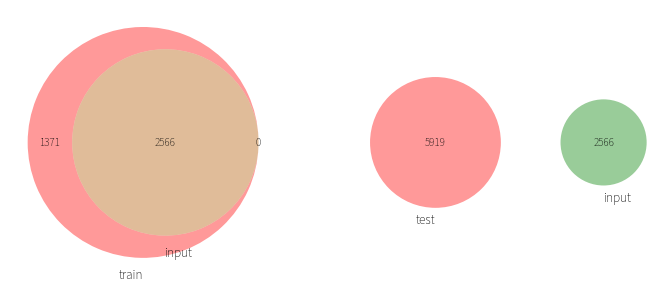

In [7]:
input_df = technique_df

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)

venn2(subsets=(
    set(train_df['object_id']), set(input_df['object_id'])
), set_labels=('train', 'input'), ax=axes[0])

venn2(subsets=(
    set(test_df['object_id']), set(input_df['object_id'])
), set_labels=('test', 'input'), ax=axes[1])

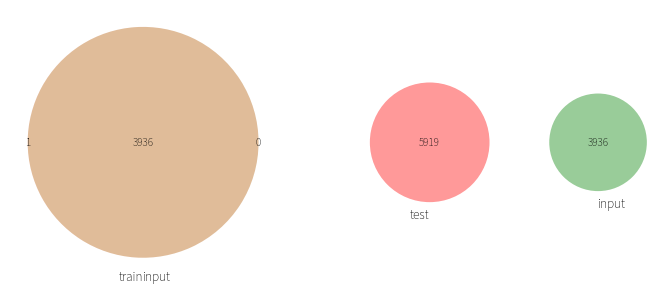

In [8]:
# material の場合
input_df = material_df

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)

venn2(subsets=(
    set(train_df['object_id']), set(input_df['object_id'])
), set_labels=('train', 'input'), ax=axes[0])

venn2(subsets=(
    set(test_df['object_id']), set(input_df['object_id'])
), set_labels=('test', 'input'), ax=axes[1])

### train.csv

In [9]:
train_df.head()

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3


`target` は年代カテゴリです。予測対象となるカラムがどういう値かはとても大事なので、今回は `target` について見ていきます。

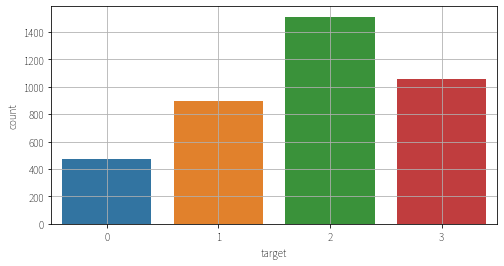

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=train_df, x='target', ax=ax)
ax.grid()

In [11]:
train_df['target'].value_counts().sort_index()

0     475
1     896
2    1511
3    1055
Name: target, dtype: int64

target は `sorting_date` から計算されているよ、とありますので、その関係性を見てみましょう。今回は `seaborn.boxen` plot を使いました。通常の統計量に加えて全体の分布も見れるので好きです。

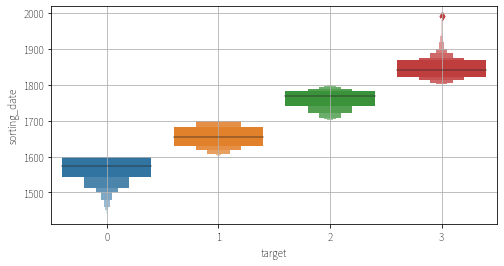

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxenplot(data=train_df, x='target', y='sorting_date', ax=ax)
ax.grid()

In [13]:
# 数字を正確に知りたい場合は groupby を使いましょう。
train_df.groupby('target')['sorting_date'].agg(['min', 'max', 'median', 'size'])

,min,max,median,size
target,,,,
0,1440,1600,1574,475
1,1601,1700,1655,896
2,1701,1800,1770,1511
3,1801,1991,1841,1055


* target と sorting_date の関係性は閾値ごとで決まっている
* 各カテゴリごとのピークは真ん中にある (黒い棒は median を表しています)

### test.csv

テスト時には object_id 以外の情報は与えられません。

* object_id は train / test でかぶっていないので、新しい画像が来てその画像の年代を推定するという問題になっていることがわかります。
* sorting_date はもちろん technique / material に関しても test の object_id には紐付かないため予測時に直接使うことは出来ません。
    * 出来ない例). 予測画像の技術が A なので年代は 0 だと予測する

In [14]:
test_df.head()

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


## 画像データを使ったモデルの作成

今回は pytorch を使ってモデルを作成していきます。

### 画像データの読み込み

In [15]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

In [17]:
img = read_image(train_df['object_id'].iat[0])

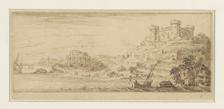

In [18]:
img

### データ拡張 (data augmentation)

画像認識などにおいては予測は入力変数がある変換を受けても変動しない性質(これを不変性と呼びます)が求められることがあります。例えば画像から数字を認識する問題であれば、数字の位置がずれている時も同じ予測値を返して欲しい (平行移動不変性を持ってほしい) です。

不変性を獲得するために、データ拡張と呼ばれる方法がよく用いられます。これは入力されるデータXを少し変更した X'をモデルに入れて出力を得た時もXと同じ出力を得られるように学習をする方法です。イメージ的には、画像がちょっとぐらい変わっても予測は変わらないよねというのを学習することに対応しています。

データ拡張にはいろいろな方法があります。例えば以下のような物があります。

* 左右を入れ替える
* 上下を入れ替える
* ランダムに画像を切り出す
* 色相を変化させる

今の予測対象において求められている不変性を考えてデータ拡張を選ぶのが良いでしょう。

### データ拡張の実装

いちから実装する必要はなく大抵のものは用意されています。例えば pytorch では torchvision.transforms モジュールによく使われる拡張が実装されています。

In [19]:
from torchvision import transforms as T

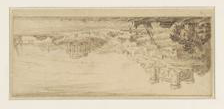

In [20]:
# p は変更する確率を表しています。今は変換がされた時の値を見たいので 1 を指定しました。
T.RandomVerticalFlip(p=1)(img)

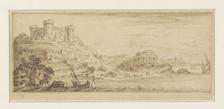

In [21]:
T.RandomHorizontalFlip(p=1)(img)

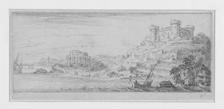

In [22]:
T.RandomGrayscale(1)(img)

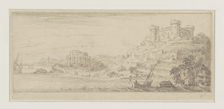

In [23]:
# 明るさ・コントラスト・彩度をランダムに変動させる
T.ColorJitter(brightness=.3, contrast=.5, saturation=[.8, 1.3])(img)

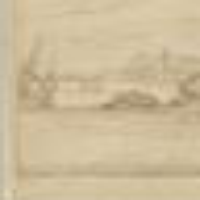

In [24]:
T.RandomResizedCrop(size=(200, 200), )(img)

学習の際には求める不変性の変換器をいくつも適用したい場合があります。この場合には T.Compose を使うと並べた順番に変換を適用してくれます。

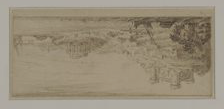

In [25]:
converter = T.Compose([
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=.5, contrast=.5)
])

converter(img)

### モデルの定義

In [26]:
import torch
from torchvision.models import resnet34
from torch import nn

In [27]:
model = resnet34(pretrained=False)

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
converter = T.Compose([
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=.5, contrast=.5),
    T.ToTensor()
])

In [30]:
x = converter(img)

In [31]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [32]:
type(x)

torch.Tensor

In [33]:
x.shape

torch.Size([3, 109, 224])

In [34]:
x.unsqueeze(0).shape

torch.Size([1, 3, 109, 224])

In [35]:
output = model(x.unsqueeze(0))

In [36]:
output.shape

torch.Size([1, 1000])

タスクの出力は年代の1次元なので最終層を書き換えておきましょう。

In [37]:
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [38]:
model(x.unsqueeze(0))

tensor([[0.5594]], grad_fn=<AddmmBackward>)

## 学習のスキームを定義する

これでモデルを使って予測値を出力することは出来るようになりました! ただ今のままでは単なるランダムな出力になっていますので、これをデータに合わせて「あるデータXを入れた時は、Xの年代yを出力する」ように修正していく必要があります。ざっと流れを書くと以下のようになります。

1. 入力データ x をモデルに入れて出力 z を作成
2. x に対応する正解ラベル y と z を目的関数に入れてどのぐらいずれいているか(loss)を計算
3. lossの情報を元にして最適化手法によってモデルを更新

### 目的関数の定義

2 のフェーズで予測した値がどのぐらい良いのか悪いのか(loss)を数値的に判断する必要があります。このlossを算出する関数を目的関数 (Objective) とよびます (criterion という変数名で定義することが多いです)。今回のコンペの指標は RMSE ですのでこれに合わせて MSELoss を使います。

In [39]:
criterion = nn.MSELoss()

In [40]:
(3 - 10) ** 2

49

In [41]:
criterion(torch.Tensor([3]), torch.Tensor([10]))

tensor(49.)

### 最適化手法の定義

目的関数で今の良さ悪さは判定できました。次に必要なのがその情報をつかってモデルをどのように修正するか、のやり方です。このやり方のことを最適化手法 (Optimizer) とよびます。現在の NN では確率的勾配法 (SGD) をベースとした最適化手法を使うことが多いです。

![](https://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif)

上記はSGDの動きを可視化したものです。等高線が目的関数の値で、これが小さいところを探しています。

最適化手法は多数提案されてて、任意のタスクに対してこれが一番と決まったものがないのですが最近では Adam や AdamW などが使われることが多いようです。今回は Adam をつかって行きます。

#### 参考文献

* [実務で使えるニューラルネットワークの最適化手法](https://acro-engineer.hatenablog.com/entry/2019/12/25/130000)
* [確率的勾配法のはなし](https://speakerdeck.com/nyk510/que-lu-de-gou-pei-fa-falsehanasi)
    * 僕のスライドです。sgd が何をやっているのか, adam とは何が違うかについてざっくりと説明しています。

In [42]:
from torch.optim import Adam

# 最適化手法の定義. どのモデルのパラメータを更新したいか、を第一引数にする
# lr は learning_rate の略. 正解はないのですが adam だと 1e-3 などが使われることが多いです
optimizer = Adam(params=model.parameters(), lr=1e-3)

### 学習をする

では実際に学習を行ってみましょう! 流れは上記で紹介したとおりです。

In [43]:
# 1. データを torch.Tensor の形式で用意
x = converter(img)
x = x.unsqueeze(0)

label = train_df['target'].iat[0]
label = torch.Tensor([label])
label = label.reshape(-1, 1)

# 2. モデルに入れて loss を objective で計算
output = model(x)
loss = criterion(output, label)

# 3. loss から optimizer が model を更新

# zero_grad は今ある勾配の情報をリセットする関数. このあとに計算される勾配を元にして最適化される
optimizer.zero_grad()

# loss から勾配を計算
loss.backward()

# 最適化ステップを一つすすめる
optimizer.step()

print(loss.item())

0.18765418231487274


### 学習を関数化する

さあ、これで学習をすすめることは出来るようになりました。がこのままだといちいち画像をとってきてそれをモデルに入れてなど大変です。また上記では簡単のため画像1枚だけでステップをすすめましたが、通常は複数枚同時にロスを計算する場合が多いですが、それをいちいち自分で実装していると大変です。(ちなみにですがこの一つの塊をミニバッチ (mini-batch) とよびます。)

幸いなことに pytorch ではデータ読み出し等に関する便利なクラスが用意されていますので、それを使っていきましょう。

#### torch.utils.data.DataSet の活用

いろいろと書いていますが基本的に必要なのは `__getitem__` と `__len__` の2つです。

ひとつ目の `___getitem__` は index の int を引数にとって、その時のデータを返す関数とする必要があります。以下では画像を変換したものと、その正解ラベルを変換しています。

ふたつ目の `__len__` は `len` を呼ばれた時の長さを返すものです。これによってこのデータの長さを外部から参照できるため、たとえば「データ全部を見終わったら終わりにする」といった処理を、このクラスの外側で書くことが出来ます。

In [44]:
from torch.utils import data

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります
            
            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [45]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)

また dataset をミニバッチ化して for 文で廻せるようにしてくれる DataLoader というクラスもあります。DataLoader クラスは iterator なため `for .... in data_loader` という書き方でミニバッチをどんどんと生成してくれます。また、単にミニバッチを作成してくれるだけでなく並列処理もやってくれて便利です。

In [46]:
# この場合同時に 54 個の画像に対応した tensor と label が作られる
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=4)

ちょっと for の中身でどうなるかを確認してみましょう。

In [47]:
for x_tensor, y in loader:
    break

In [48]:
# 最初の次元が先に設定した 54 になっている
x_tensor.shape, y.shape

(torch.Size([54, 3, 224, 224]), torch.Size([54]))

### 学習関数の実装

In [49]:
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")

In [50]:
from torch.optim.optimizer import Optimizer
from collections import defaultdict

def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()
    
    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)
    
    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

上記を使うと学習は以下のように書くことが出来ます。

In [52]:
from vivid.utils import timer

n_epochs = 10

# GPU 環境で学習するため変換. この呼び出しは破壊的
model.to(DEVICE)
optimizer = Adam(params=model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    
    with timer(prefix="train: epoch={}".format(epoch)):
        score_train = train(
            model, optimizer, train_loader=loader
        )
    print(score_train)
    
    break

train: epoch=1 13.904[s]
train_loss    2.29936
dtype: float64


## モデル作成の基本的な考え方

さて学習の枠組みは完成しましたが一般にはこれに検証のフェーズを組み込んで学習をします。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### 交差検証によるモデルの性能見積もり

交差検証 (Cross Validation) とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### 交差検証はなぜ必要か

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

検証のためのデータ分割手法は sklearn.model_selection モジュールに定義されています。今回はもっとも単純な KFold を使って学習を行います。

### NOTE: データ分割の方法は重要です

分割方法はモデルの性能の見積もりにもっとも密接に関わりますので今後予測する状態を考えて慎重に選択する必要があります。例えば天気予報をしたい(未来の予測をしたい)のにもかかわらず、日付を考慮せずに KFold したとします。この場合、学習データに前日と次の日の天気があって、その真ん中の日を予測するような条件が発生する可能性があります。この場合検証のスコアは実際に天気予報を運用した時に得られないことはわかるでしょう。この場合ある時刻を基準として過去・未来で分割することが必要です。

今回のコンペティションにおいても train / test がどう分かれているかを考慮して、それを交差検証の分割にも反映しより正確にモデルの性能を見積もると良いでしょう。(が今回は触れません) [CV vs LB](https://www.guruguru.science/competitions/17/discussions/f1c8c1d7-7698-4ac0-9982-10e35952ff6e/) のスレッドで分割方法を記載している方もいますので、そちらも参考にすると良いかもしれません。

![kfold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

In [53]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))

fold 内の train / valid の確認

In [66]:
idx_tr, idx_val = cv[0]

len(idx_tr), len(idx_val)

(3149, 788)

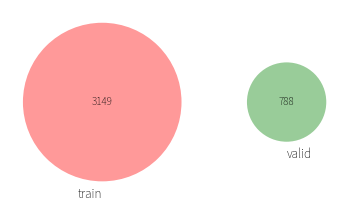

In [69]:
# train / valid で index の重複はない
venn2(subsets=(set(idx_tr), set(idx_val)), set_labels=('train', 'valid'))

### note:

場合によっては fold すべての学習せず、最初の fold のみで検証する場合があります。こうすることで、見積もりの正確性は落ちますが、たくさんの実験パターンを実行できるというメリットがあります。特に一つの fold の学習にとても時間がかかる場合、実験条件のPDCAを回す速度を優先して fold を削ることがあります。

たとえば最初の fold だけで考えるよ〜という時は以下のコードを埋め込みましょう。

```python
# 最初の fold だけで考える
cv = cv[:1]
```

### 検証フェーズの実装

検証用データでのスコア確認をするためにいくつか関数を実装します。

* predict: 与えられたデータ (data-loader) に対しての予測値を計算
* valid: 与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す

In [56]:
# from vivid.metrics import regression_metrics
from sklearn.metrics import mean_squared_error


def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()
    
    predicts = []
    
    for x_i, y_i in loader:
        
        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)
    
    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """
    
    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)
    
    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [57]:
from tabulate import tabulate


def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    os.makedirs(output_i, exist_ok=True)
    
    # 0: 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    # 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)

    # --- 保存のための変数定義
    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None
    
    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        
        # 1: 学習用データで学習を実行。学習時のロスを取得
        with timer(prefix="train: epoch={}".format(epoch)):
            score_train = train(
                model, optimizer, train_loader
            )

        # 2: 検証データでのスコアを計算
        with timer(prefix="validate"):
            score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)
            
            
        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---
        
        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_best_pred = y_valid_pred
    
    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return y_valid_pred

### CrossValidationの枠組みで学習の実行

cv ごとに train / valid を区切って学習を行います。`train_meta_df` を iloc をつかって cv の train / valid に分割していることに注意してください。

In [58]:
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    output_i = get_output_dir(i)
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    
    model.to(DEVICE)
    
    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,
        
        # 今は 1 ですぐ終わるようにしている. 本当は validation score の値を見つつ適宜設定する
        n_epochs=1
    )
    
    oof[idx_valid] = oof_i

start 1
train: epoch=1 10.489[s]
validate 1.569[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       3.46222       1.87201        1
validation score is improved!! inf -> 1.8720
start 1
train: epoch=1 10.508[s]
validate 1.753[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       7.28837       2.51989        1
validation score is improved!! inf -> 2.5199
start 1
train: epoch=1 11.065[s]
validate 1.815[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       3.42927       1.85707        1
validation score is improved!! inf -> 1.8571
start 1
train: epoch=1 10.612[s]
validate 1.732[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0        5.9048       2.41774        1
validation score is improved!! inf -> 2.4177
start 1
train: epoch=1 10.365[s]
validate 1.495[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0   

### FoldOutした予測値でのスコア確認

この値が手元で見積もった今の学習方法での検証スコアになります。この値とLBの値が相関しているか?がひとつのチェックポイントです。手元のスコアは良いのにLBのスコアが悪い場合には、モデルの性能を過剰に見積もっているといえます。

この場合はデータに過剰に fitting していたり、CrossValidationの仕組みが良くない可能性がありますので CV のやリ方や学習に使うデータの作成方法を見直します。

In [59]:
calculate_metrics(train_df['target'], oof)

{'rmse': 2.1828628745414136}

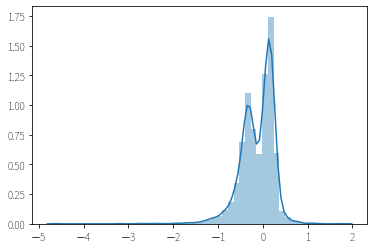

In [60]:
sns.distplot(oof)

## Submission を作る

テスト用にデータセットを作りましょう。これは学習時に作ったものと同じですが `is_train` の指定だけ注意をしてください。

In [61]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)
    
    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)


学習したモデルを使って submission を作りましょう。CV のフェーズで `model_best.pth` という名前で重みを保存していますのでそれを読み込んで予測関数 `predict` に入れるを繰り返していきます。

In [62]:
test_predictions = []

for i in range(len(cv)):
    output_i = get_output_dir(i)
    
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    
    # 最も良かった重みを読みだす
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(output_i, 'model_best.pth')
    
    model.load_state_dict(torch.load(model_path))
    
    # GPU環境で予測するため `to` で変換
    model.to(DEVICE)
    
    with timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    test_predictions.append(y_pred_i)

pred cv=0 6.307[s]
pred cv=1 7.476[s]
pred cv=2 6.934[s]
pred cv=3 6.924[s]
pred cv=4 6.554[s]


#### submission file として保存

In [63]:
# すべての予測の平均値を使う
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, "0001__submission.csv"), index=False)